## Loading Packages

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.stats import gaussian_kde
import umap
import os
import fcsparser

# -------------------------------------------- #

import cellCnn
from cellCnn.utils import loadFCS, ftrans, mkdir_p, get_items
from cellCnn.model import CellCnn
from cellCnn.plotting import plot_results


## Define WDIR and Paths

In [72]:
# Define input and output directories
WDIR = os.getcwd()
DATA_PATH = os.path.join(WDIR, 'data')
FCS_DATA_PATH = os.path.join(DATA_PATH, 'gated_NK')
DATA_LABELS_PATH = os.path.join(DATA_PATH, 'NK_fcs_samples_with_labels.csv')
MARKERS_PATH = os.path.join(DATA_PATH, 'NK_markers.csv')
OUTPUT_PATH = os.path.join(WDIR, 'output')

## Load Data

In [ ]:
# Load fcs file labels
labels = pd.read_csv(DATA_LABELS_PATH)

# Load FCS data and add labels to the data for every file from the labels file 
def load_fcs_data(fcs_folder):
    data_list = []
    for filename in os.listdir(fcs_folder):
        if filename.endswith(".fcs"):
            path = os.path.join(fcs_folder, filename)
            meta, data = fcsparser.parse(path)
            data.head()
            data['filename'] = filename
            data['label'] = labels[labels['fcs_filename'] == filename]['label'].values[0]
            data_list.append(data)
    return pd.concat(data_list)

data = load_fcs_data(FCS_DATA_PATH)


In [87]:
# count the number of row by label
data['label'].value_counts()

label
0    140007
1    121586
Name: count, dtype: int64

In [88]:
# Random sampling without replacement
sample_size = 50000  # Desired number of samples
subsample = data.sample(n=sample_size, random_state=42, ignore_index=True)
data = subsample

In [89]:
## Filter data by the markers of interest
data_labels = data['label']
markers = ['CD3', 'CD27', 'CD19', 'CD4', 'CD8', 'CD57', '2DL1-S1', 'TRAIL', '2DL2-L3-S2',
           'CD16', 'CD10', '3DL1-S1', 'CD117', '2DS4', 'ILT2-CD85j', 'NKp46', 'NKG2D',
           'NKG2C', '2B4', 'CD33', 'CD11b', 'NKp30', 'CD122', '3DL1', 'NKp44', 'CD127', '2DL1',
           'CD94', 'CD34', 'CCR7', '2DL3', 'NKG2A', 'HLA-DR', '2DL4', 'CD56', '2DL5', 'CD25']

data = data[markers]
data.head()

CD3      CD27      CD19       CD4         CD8       CD57    2DL1-S1  \
0  53.659119 -0.371095 -0.307544 -0.649640   -0.513070  -0.624067  -0.893664   
1  47.485229 -0.403747 -0.416181 -0.035566  201.634323  20.030581  14.691544   
2  -0.585389 -0.951392 -0.837678 -0.129374   23.454857  16.427032  -0.860123   
3  23.418510 -0.310379  4.497980 -0.738929   -0.715094   1.330287  -0.728412   
4  66.551460 -0.638177 -0.739940  0.699423   -0.831533  70.298401  15.454774   

      TRAIL  2DL2-L3-S2        CD16  ...        CD94      CD34      CCR7  \
0 -0.977706   -0.663983   -0.446946  ...   41.924896  0.823193  5.650387   
1 -0.708685    3.447114    3.349473  ...    5.523597 -0.777265 -0.136528   
2 -0.586759   -0.138632   14.336022  ...   -0.544208 -0.368114 -0.145485   
3 -0.922577   -0.362517    0.584142  ...   27.664043  1.782975  1.196899   
4 -0.728628   19.808475  147.560867  ...  232.020386  7.375746  5.553711   

       2DL3       NKG2A     HLA-DR      2DL4        CD56      2DL5      CD25  
0 -0.626956   28.097288  32.039948 -0.882955   30.883974 -0.967420 -0.529696  
1 -0.260791   -0.483527  34.840454 -0.968930   13.646080  3.004937 -0.640216  
2 -0.473295   -0.121391  14.639469 -0.835927   -0.486463 -0.044394 -0.641811  
3  6.604880    1.677152   6.274468  7.952677  110.813583 -0.323268 -0.269360  
4  1.860304  153.930038  16.071686  6.287660  217.997589  0.550026 -0.391187  

[5 rows x 37 columns]

In [90]:
data.shape

(50000, 37)

## EDA

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
# Plot histograms for selected markers
select_markers = ['CD3', 'CD27', 'CD19']  # Replace with the marker names in your dataset

def plot_hist(data, select_markers, markers_per_grid=10, cap_outliers=True):
    num_grids = math.ceil(len(select_markers) / markers_per_grid)
    
    for i in range(num_grids):
        # Get the subset of markers
        markers_subset = select_markers[i * markers_per_grid:(i + 1) * markers_per_grid]
        
        # Handle outliers by capping extreme values
        if cap_outliers:
            data_capped = data[markers_subset].apply(lambda x: np.clip(x, a_min=np.percentile(x, 1), a_max=np.percentile(x, 99)))
        else:
            data_capped = data[markers_subset]
        
        # Log-transform the intensity values
        data_log = data_capped.apply(np.log1p)  # log1p to safely handle zeros
        data_long = data_log.melt(var_name='Marker', value_name='Log Intensity')
        
        # Create the FacetGrid with log-log scale and dynamic binning
        g = sns.FacetGrid(data_long, col='Marker', col_wrap=5, height=3, aspect=1.2, palette="husl")
        g.map(sns.histplot, 'Log Intensity', bins=70, kde=True, kde_kws={'bw_adjust': 0.8}, color='blue', alpha=0.3)
        
        # Apply log scale to the y-axis for frequency
        for ax, marker in zip(g.axes.flat, markers_subset):
            ax.set_yscale('log')
            # Set x-axis limits to focus on meaningful intensity ranges
            ax.set_xlim(-2, 2)
            
            # Add statistical annotation (mean)
            mean_intensity = np.mean(data[marker].apply(np.log1p))
            ax.axvline(mean_intensity, color='red', linestyle='--')
            ax.text(mean_intensity, ax.get_ylim()[1]*0.9, f'Mean: {mean_intensity:.2f}', color='red')
        
        # Set titles and labels
        g.set_titles('{col_name}')
        g.set_axis_labels('Log(Intensity)', 'Log(Frequency)')
        
        # Tight layout for better spacing
        plt.tight_layout()
        plt.show()

# Test plot
#plot_hist(data, select_markers)

In [92]:
# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

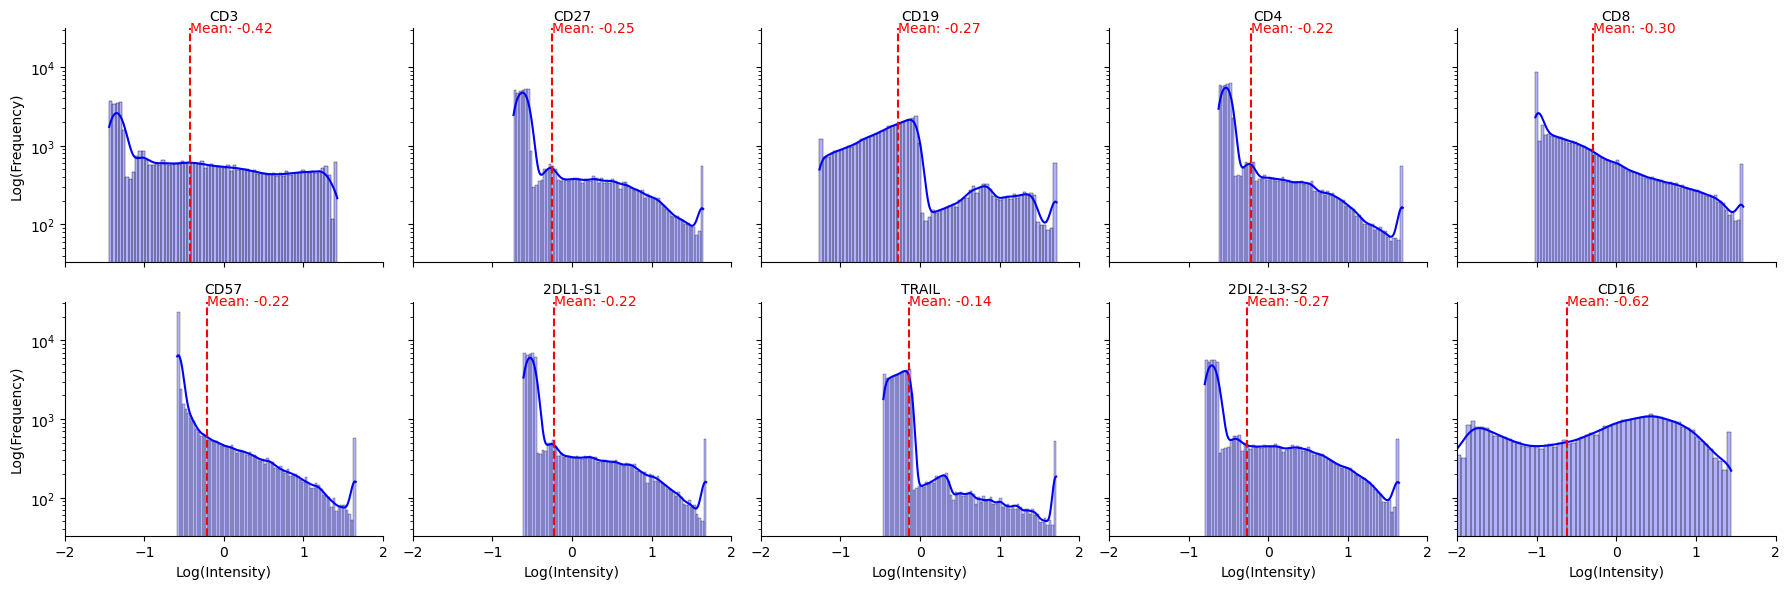

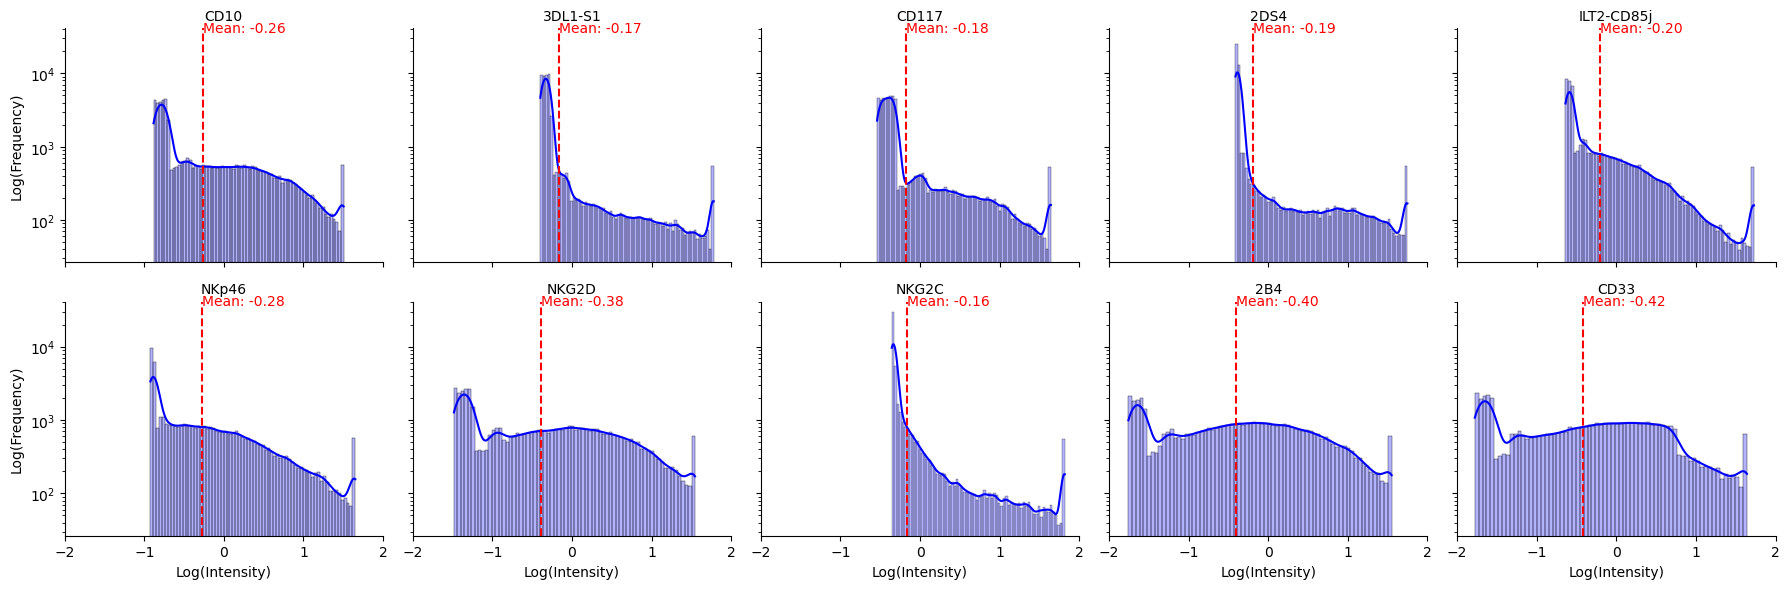

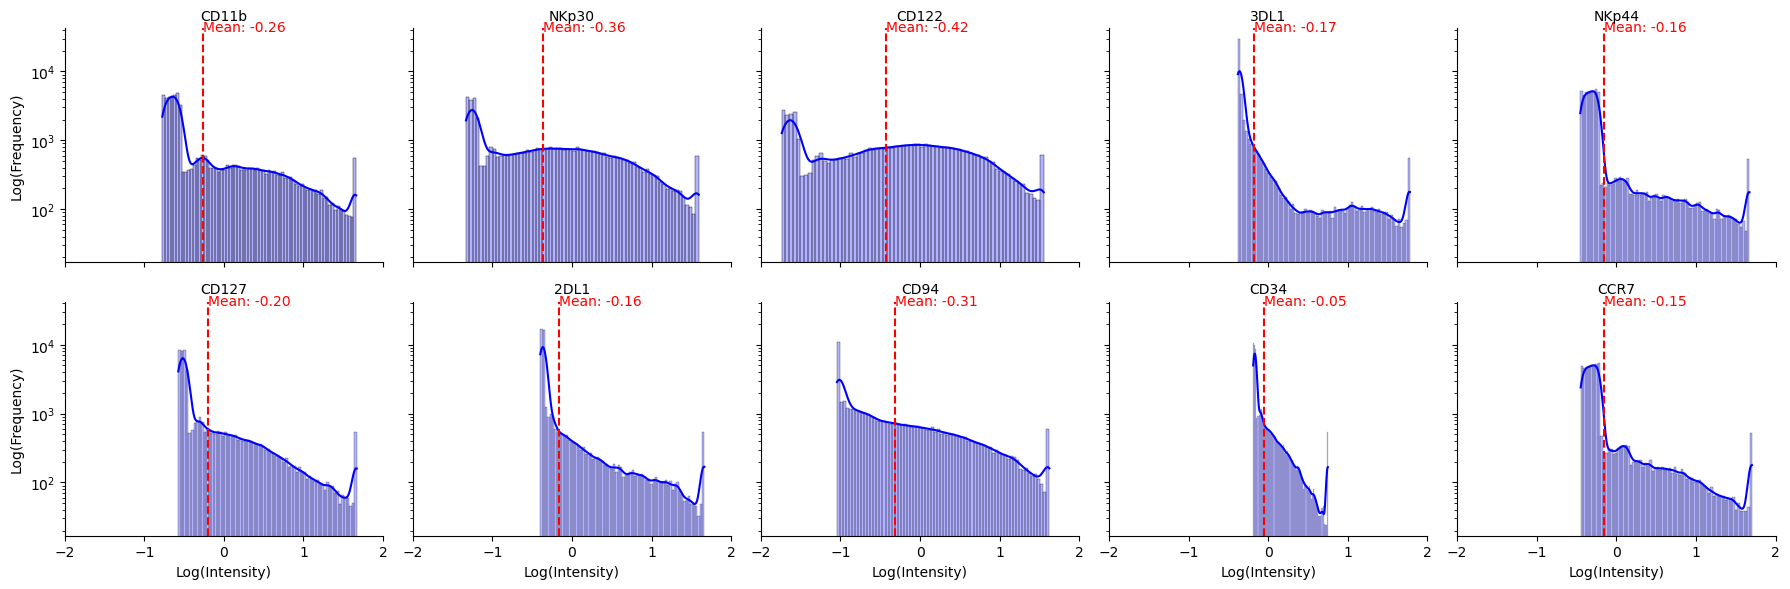

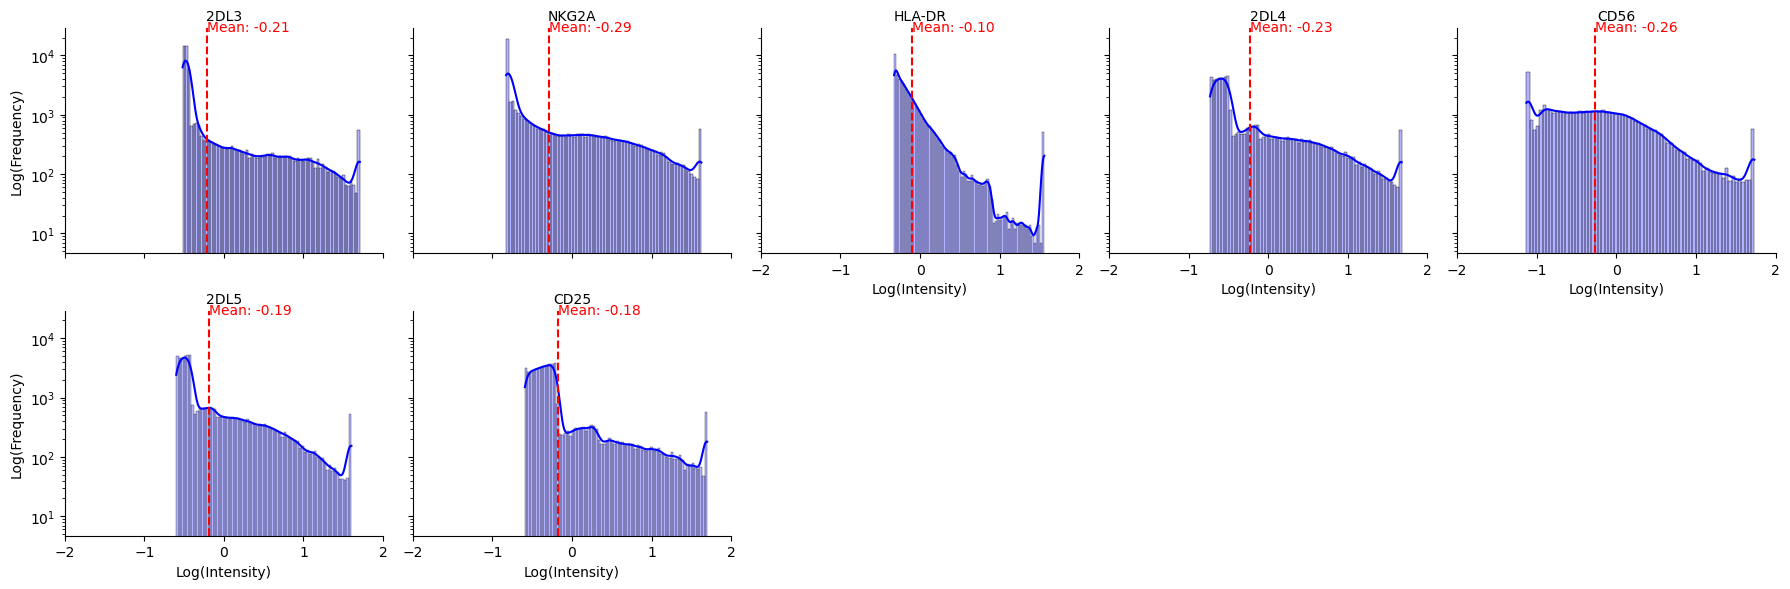

In [93]:
plot_hist(pd.DataFrame(scaled_data, columns=data.columns), markers)

In [94]:
def plot_density(embedding, method):
    # Extract the components
    x = embedding[:, 0]
    y = embedding[:, 1]

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort points by density for better visualization
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    plt.figure(figsize=(10, 6))

    # Scatter plot for the points
    scatter = plt.scatter(x, y, c=z, cmap='viridis', s=5)

    # Add KDE contours
    sns.kdeplot(x=x, y=y, levels=5, color='black', linewidths=1, fill=True, alpha=0.2, bw_adjust=0.7)

    # Add colorbar
    plt.colorbar(scatter, label='Density')

    plt.title(f'{method} Plot with Density Contours')
    plt.xlabel(f'{method} Component 1')
    plt.ylabel(f'{method} Component 2')
    plt.show()

### PCA

In [95]:
def apply_pca(data, n_components=15):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)
    return pca_result

# Apply PCA
pca_result = apply_pca(scaled_data)

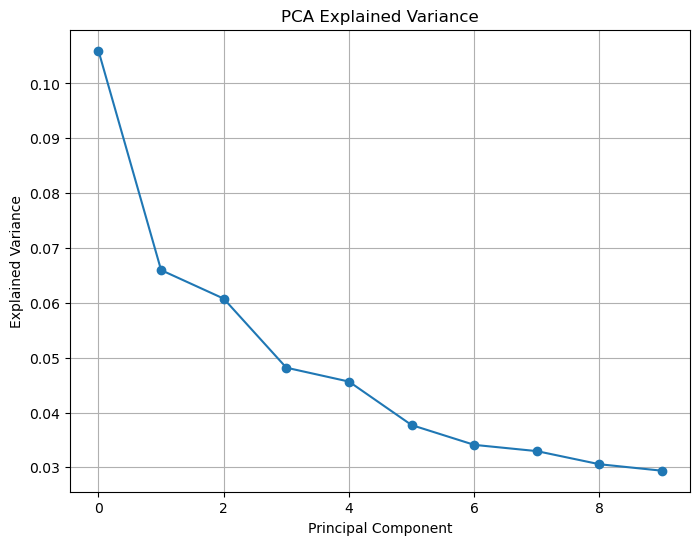

In [97]:
## plot pca variance explained by each component 
def plot_pca_variance(data, n_components=10):
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)

    plt.figure(figsize=(8, 6))
    plt.plot(pca.explained_variance_ratio_, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.show()

plot_pca_variance(scaled_data, n_components=10)

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


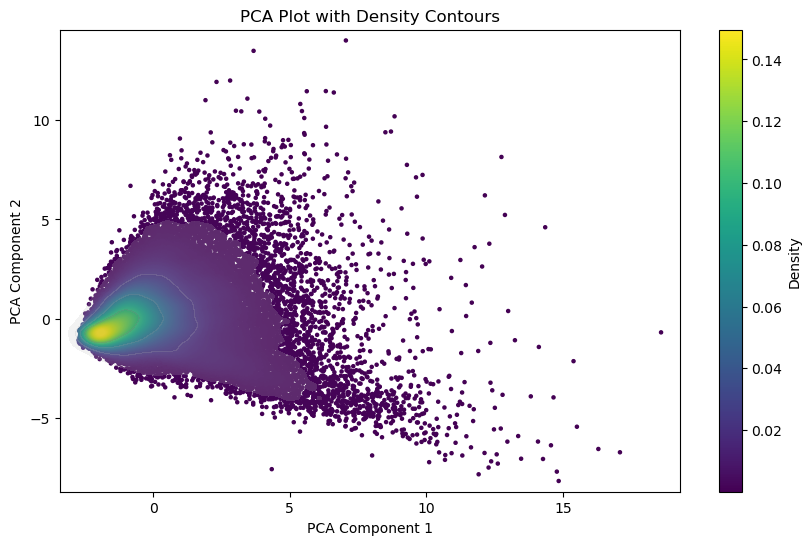

In [98]:
plot_density(embedding=pca_result, method="PCA")

### t-SNE

In [99]:
def apply_tsne(data, perplexity=30, n_components=2, learning_rate=200, n_iter=1000):
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    tsne_result = tsne.fit_transform(data)
    return tsne_result

# Apply t-SNE
tsne_result = apply_tsne(pca_result)

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


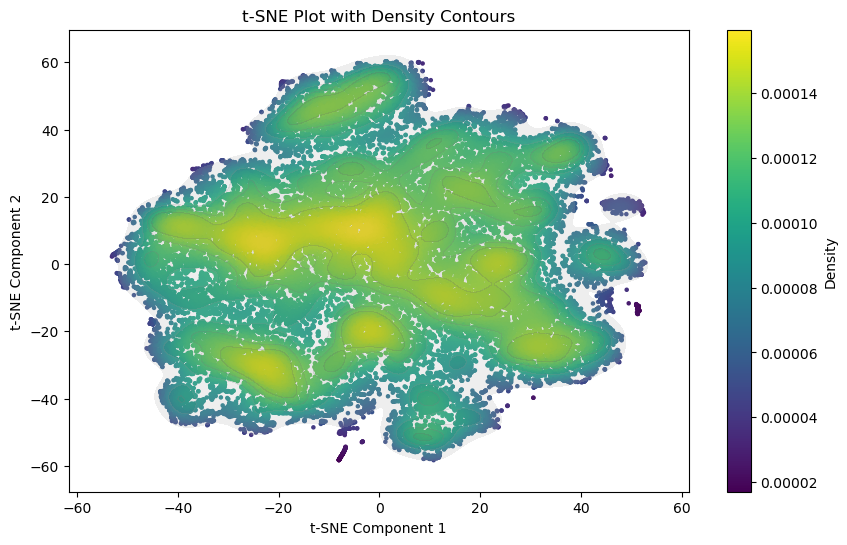

In [100]:
# Example for t-SNE
plot_density(embedding=tsne_result, method="t-SNE")

### UMAP

In [101]:
def apply_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean'):
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)
    umap_result = reducer.fit_transform(data)
    return umap_result
    
# Apply UMAP
umap_result = apply_umap(pca_result)

/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/seaborn/distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


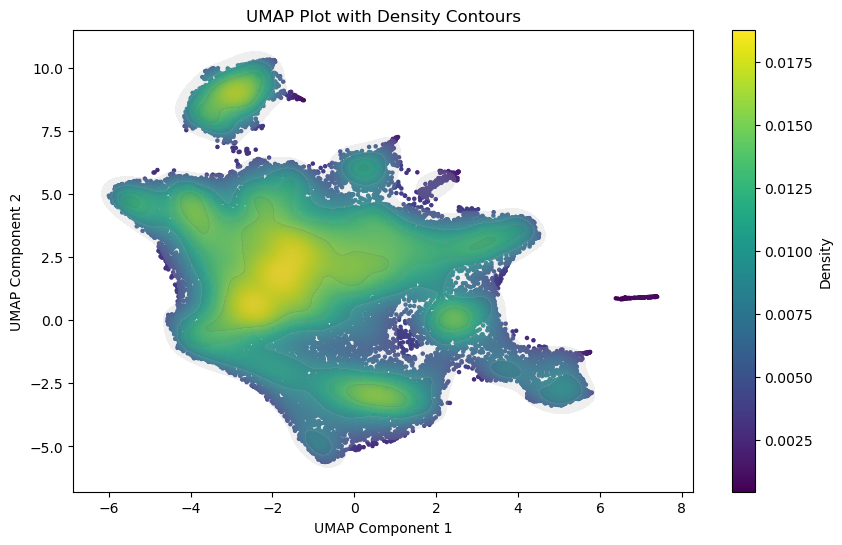

In [102]:
plot_density(embedding=umap_result, method="UMAP")

## Comparing the Methods

In [103]:
# Calculate Silhouette Scores for PCA, t-SNE, and UMAP
def calculate_silhouette(data, labels):
    return silhouette_score(data, labels)

# Using PCA, t-SNE, and UMAP results as labels for silhouette score
pca_silhouette = calculate_silhouette(scaled_data, pca_result[:, 0])
tsne_silhouette = calculate_silhouette(scaled_data, tsne_result[:, 0])
umap_silhouette = calculate_silhouette(scaled_data, umap_result[:, 0])

print(f"Silhouette score for PCA: {pca_silhouette}")
print(f"Silhouette score for t-SNE: {tsne_silhouette}")
print(f"Silhouette score for UMAP: {umap_silhouette}")


Silhouette score for PCA: -0.00048676328151486814
Silhouette score for t-SNE: -0.0005632989341393113
Silhouette score for UMAP: -0.0007580032106488943


## Clustering

### K-means

In [104]:
from sklearn.cluster import KMeans

def apply_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)
    return kmeans_labels

# Apply KMeans
kmeans_labels = apply_kmeans(pca_result, n_clusters=8)


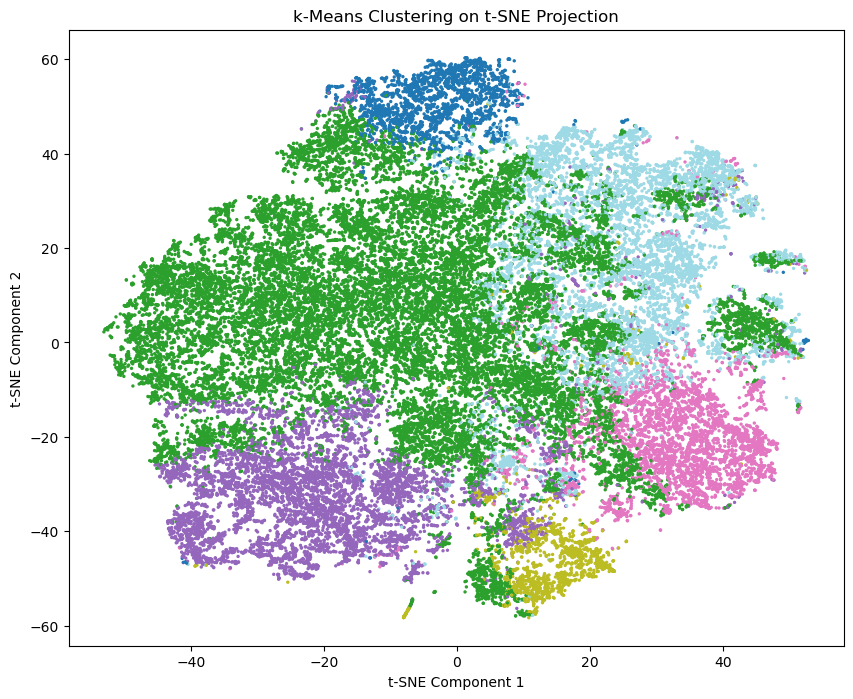

In [141]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_labels, cmap='tab20', s=2)
plt.title('k-Means Clustering on t-SNE Projection')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

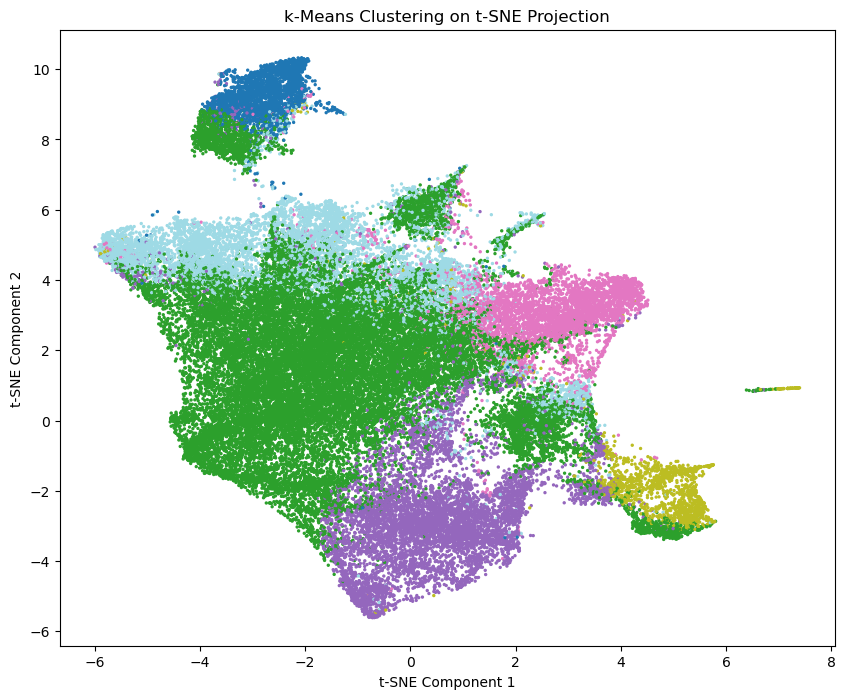

In [142]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_labels, cmap='tab20', s=2)
plt.title('k-Means Clustering on UMAP Projection')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

### Hierarchical

In [108]:
from scipy.cluster.hierarchy import linkage, fcluster

def apply_hierarchical(data, n_clusters):
    Z = linkage(data, method='ward')
    hierarchical_labels = fcluster(Z, n_clusters, criterion='maxclust')
    return hierarchical_labels

# Apply Hierarchical Clustering
hierarchical_labels = apply_hierarchical(pca_result, n_clusters=8)

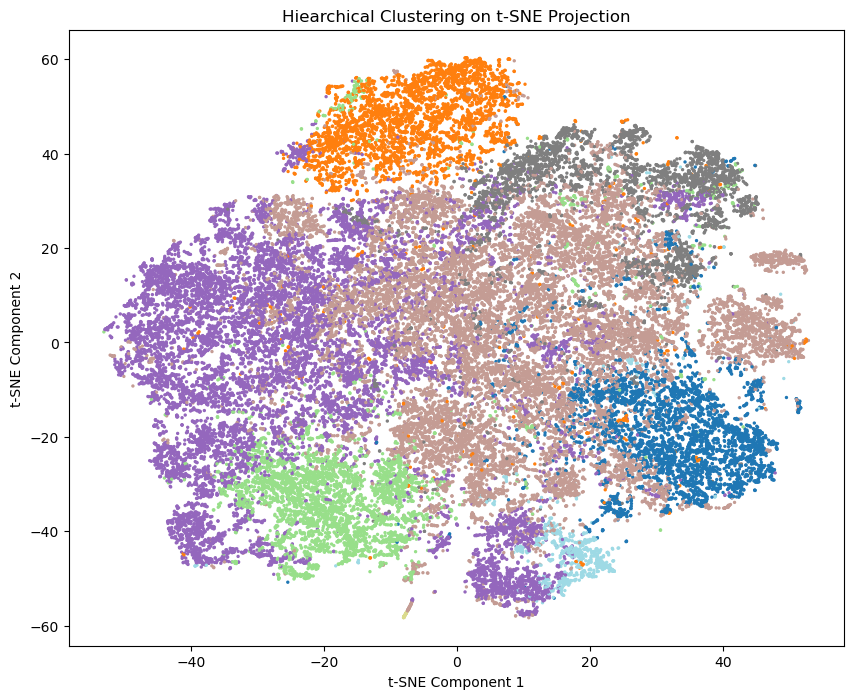

In [140]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=hierarchical_labels, cmap='tab20', s=2)
plt.title('Hiearchical Clustering on t-SNE Projection')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

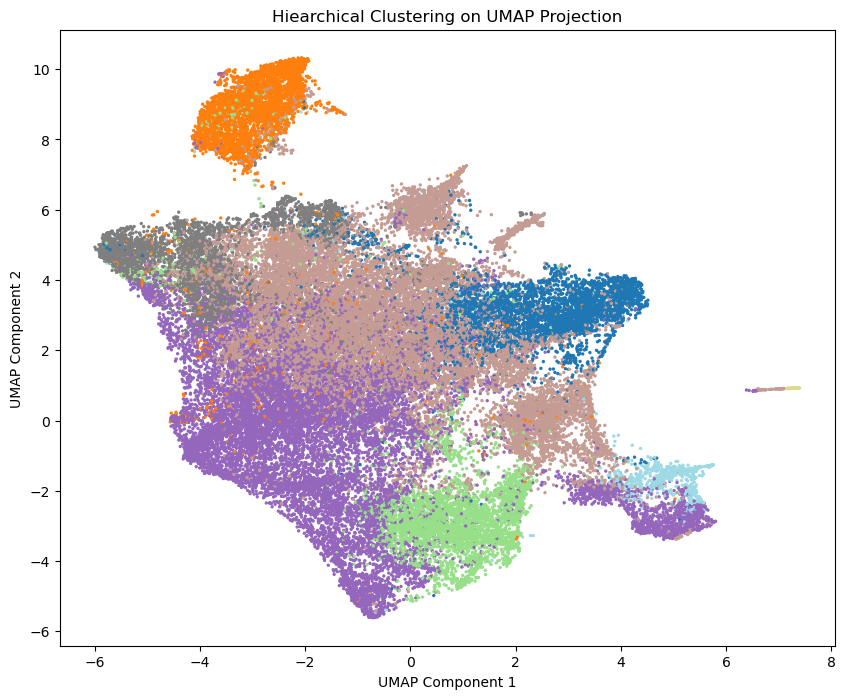

In [143]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=hierarchical_labels, cmap='tab20', s=2)
plt.title('Hiearchical Clustering on UMAP Projection')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

### Leiden

In [144]:
from sklearn.neighbors import NearestNeighbors
import igraph as ig
import leidenalg

In [123]:
# Construct k-NN Graph
n_neighbors = 15
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(pca_result)
knn_graph = knn.kneighbors_graph(pca_result, mode='connectivity')

In [145]:
# Applying Leiden Clustering
sources, targets = knn_graph.nonzero()
edges = list(zip(sources, targets))
g = ig.Graph(edges=edges, directed=False)
weights = knn_graph.data
g.es['weight'] = weights

partition = leidenalg.find_partition(
    g,
    leidenalg.RBConfigurationVertexPartition,
    weights=g.es['weight'],
    resolution_parameter=0.6
)
leiden_labels = np.array(partition.membership)


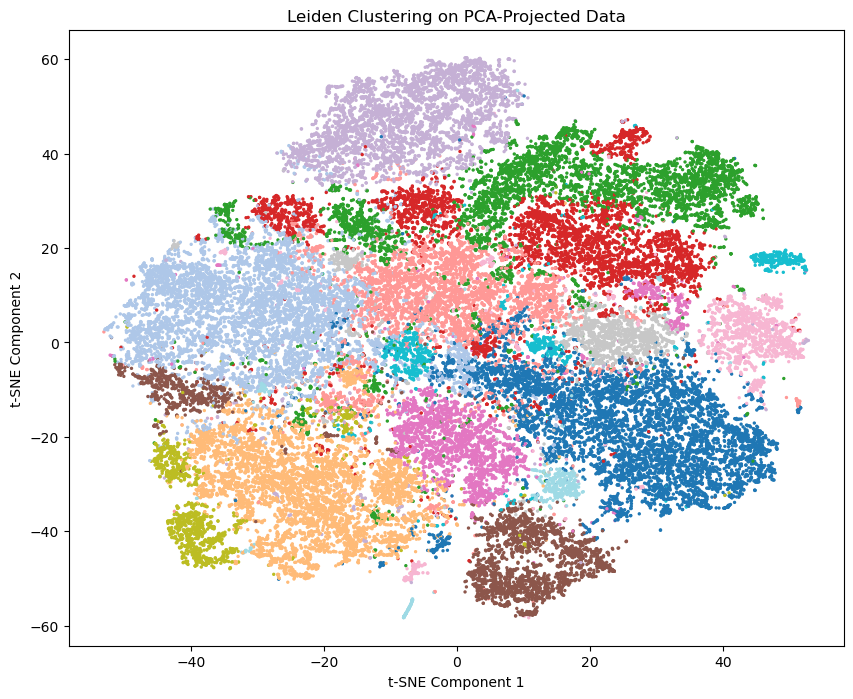

In [146]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=leiden_labels, cmap='tab20', s=2)
plt.title('Leiden Clustering on t-SNE Projection')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

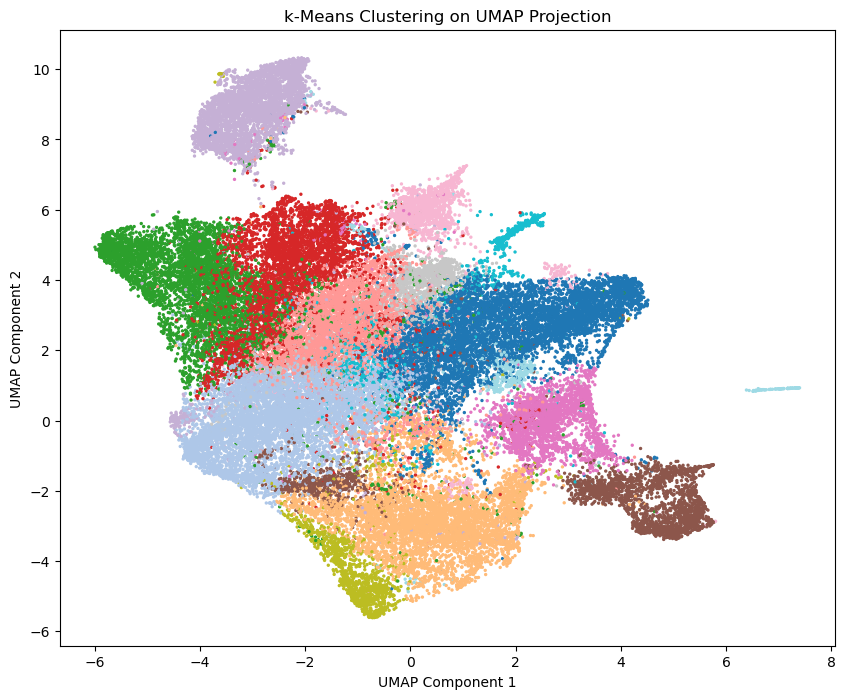

In [147]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=leiden_labels, cmap='tab20', s=2)
plt.title('k-Means Clustering on UMAP Projection')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

### Comparing the Methods

In [ ]:
true_labels = data_labels

# Adjusted Rand Index
kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels)
hierarchical_ari = adjusted_rand_score(true_labels, hierarchical_labels)
leiden_ari = adjusted_rand_score(true_labels, leiden_labels)

# Silhouette Score
kmeans_silhouette = silhouette_score(scaled_data, kmeans_labels)
hierarchical_silhouette = silhouette_score(scaled_data, hierarchical_labels)
leiden_silhouette = silhouette_score(scaled_data, leiden_labels)

# Print Results
print(f"k-means ARI: {kmeans_ari}, Silhouette: {kmeans_silhouette}")
print(f"Hierarchical ARI: {hierarchical_ari}, Silhouette: {hierarchical_silhouette}")
print(f"Leiden ARI: {leiden_ari}, Silhouette: {leiden_silhouette}")


## Comparative Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import fcsparser
import umap
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


/opt/miniconda3/envs/single-cell-playground/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Feature prep

In [9]:
import os
from sklearn.preprocessing import StandardScaler


# Split into features and target (assuming the target is in the 'cell_type' column)
X = scaled_data
y = data_labels # replace with actual label

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy}")


Logistic Regression Accuracy: 0.6640417439171238


### SVM

In [13]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.7399606261587569


### Random Forest

In [23]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy}")


Random Forest Accuracy: 0.7431334696764081
